<a href="https://colab.research.google.com/github/Tomokki/private_Python-.gitkeep/blob/main/%E3%83%AC%E3%82%AF%E3%83%81%E3%83%A3%E3%83%BC3_%E6%8E%A2%E7%B4%A2%E7%9A%84%E3%83%87%E3%83%BC%E3%82%BF%E5%88%86%E6%9E%90%E3%81%A8%E5%89%8D%E5%87%A6%E7%90%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 探索的データ分析、前処理 (01_EDA_preprocess.ipynb)
予測モデルを作成する前にデータの特徴を探求し構造を理解すること目的としたデータ解析を行います  
データ理解のための最初に行う分析のことを探索的データ分析/EDA(Explanatory Data Analysis)と呼びます

### 1.1 欠損値の数とデータの型
各列について欠損値の割合を確認し割合に応じて分析に使うかどうかを判断します  
数値のデータなのか、文字列のデータなのか各列のデータの型を確認します  

### 1.2 分析ができるようにデータを前処理
数値として扱いたいデータに文字のデータが紛れていると数値として扱えず可視化することができないのでクリーニングを行います  

### 1.3 データの可視化
各列の属性を以下のグラフを用いて可視化します
可視化を行うことにより外れ値が存在するか偏りがないかをチェックしていきます
* ヒストグラム  
* カウントプロット
* ヒートマップ

In [ ]:
# ライブラリのインポートと表示の設定

import os
import gc
import time
import json
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

### 日本語表示の設定
from matplotlib import rcParams
igfont = {'family':'IPAexGothic'}
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

In [ ]:
# 読み込むデータのパスをセット
'''
settings.jsonにTrainデータ、Testデータのパスを設定し読み込みます
'''

with open("../env_settings/settings.json") as f:
    path_file=json.load(f)

TRAIN_DIR_PATH=path_file["RAW_TRAIN_DIR"]
TEST_DIR_PATH=path_file["RAW_TEST_DIR"]

PROCESSED_DATA_DIR=path_file["PROCESSED_DATA_DIR"]

In [ ]:
#対象変数名
TARGET_COL="取引価格（総額）_log"

In [ ]:
### Trainデータを読み込む関数
'''
Trainデータは 01.csv - 47.csvのように47都道府県ごとに別れております。
分析は1つのcsvに結合した状態で行いたいので、読み込みのタイミングでまとめます。
'''

def ReadRawData(path):
    file_name_list=np.sort(os.listdir(path))
    df=pd.DataFrame([])
    for file_name in file_name_list:
        df=pd.concat([df,pd.read_csv(path+"/"+file_name)])
    df=df.reset_index(drop=True)
    return df

In [ ]:
print("Read Data")
#データ読込
train_df=ReadRawData(TRAIN_DIR_PATH)
test_df=pd.read_csv(TEST_DIR_PATH)

Read Data


/Users/cn/opt/anaconda3/envs/mansion39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3301: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):


In [ ]:
train_df

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,...,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,1060685,中古マンション等,NaN,1108,北海道,札幌市厚別区,大谷地東,大谷地,8,３ＬＤＫ,...,NaN,NaN,NaN,準工業地域,60.0,200.0,2009年第４四半期,未改装,NaN,7.079181
1,1005580,中古マンション等,NaN,1101,北海道,札幌市中央区,南９条西,中島公園,5,１ＤＫ,...,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2018年第３四半期,未改装,NaN,6.755875
2,1001363,中古マンション等,NaN,1101,北海道,札幌市中央区,北３条西,西１１丁目,11,３ＬＤＫ,...,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2010年第２四半期,未改装,NaN,7.204120
3,1052374,中古マンション等,NaN,1108,北海道,札幌市厚別区,厚別中央２条,ひばりが丘(北海道),5,４ＬＤＫ,...,NaN,NaN,NaN,商業地域,80.0,400.0,2015年第３四半期,未改装,NaN,7.591065
4,1059107,中古マンション等,NaN,1108,北海道,札幌市厚別区,厚別東４条,新さっぽろ,12,４ＬＤＫ,...,NaN,NaN,NaN,準工業地域,60.0,200.0,2012年第４四半期,未改装,NaN,6.875061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637346,47006436,中古マンション等,NaN,47211,沖縄県,沖縄市,美里,NaN,NaN,３ＬＤＫ,...,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,200.0,2018年第３四半期,未改装,NaN,7.397940
637347,47016923,中古マンション等,NaN,47211,沖縄県,沖縄市,泡瀬,NaN,NaN,２ＬＤＫ,...,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,200.0,2014年第４四半期,未改装,NaN,7.041393
637348,47027429,中古マンション等,NaN,47208,沖縄県,浦添市,城間,NaN,NaN,３ＬＤＫ,...,NaN,NaN,NaN,第１種住居地域,60.0,200.0,2009年第４四半期,未改装,NaN,6.903090
637349,47001601,中古マンション等,NaN,47201,沖縄県,那覇市,松尾,県庁前(沖縄),12,４ＬＤＫ,...,NaN,NaN,NaN,商業地域,80.0,400.0,2018年第４四半期,未改装,NaN,7.342423


In [ ]:
# testデータには目的変数(取引価格（総額）_log)が含まれません
test_df

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,...,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等
0,1000000,中古マンション等,NaN,1101,北海道,札幌市中央区,旭ケ丘,円山公園,26,３ＬＤＫ,...,住宅,NaN,NaN,NaN,第１種低層住居専用地域,40.0,60.0,2020年第２四半期,未改装,NaN
1,1000056,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１１丁目,1,２ＬＤＫ,...,住宅,NaN,NaN,NaN,商業地域,80.0,600.0,2020年第１四半期,未改装,NaN
2,1000108,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１８丁目,2,１Ｒ,...,住宅,NaN,NaN,NaN,商業地域,80.0,400.0,2020年第２四半期,未改装,NaN
3,1000109,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１８丁目,2,１ＬＤＫ,...,住宅,NaN,NaN,NaN,商業地域,80.0,400.0,2020年第２四半期,改装済,NaN
4,1000110,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１８丁目,3,１Ｒ,...,住宅,NaN,NaN,NaN,商業地域,80.0,400.0,2020年第２四半期,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19461,47003828,中古マンション等,NaN,47208,沖縄県,浦添市,牧港,NaN,NaN,４ＬＤＫ,...,住宅,NaN,NaN,NaN,商業地域,80.0,400.0,2020年第１四半期,未改装,NaN
19462,47003829,中古マンション等,NaN,47208,沖縄県,浦添市,牧港,NaN,NaN,２ＬＤＫ,...,住宅,NaN,NaN,NaN,準工業地域,60.0,200.0,2020年第１四半期,改装済,NaN
19463,47003880,中古マンション等,NaN,47208,沖縄県,浦添市,港川,NaN,NaN,４ＬＤＫ,...,住宅,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,200.0,2020年第１四半期,未改装,NaN
19464,47006648,中古マンション等,NaN,47211,沖縄県,沖縄市,与儀,NaN,NaN,３ＬＤＫ,...,住宅,NaN,NaN,NaN,市街化区域及び市街化調整区域外の都市計画区域,70.0,200.0,2020年第１四半期,未改装,NaN


### 1.1 欠損値の数とデータの型
列毎にデータ・タイプや欠損値の数を確認します (Train/Test)

※欠損値とは空欄になっているデータのことでExcelで表示すると以下の画像のような箇所です

<img src="../image/欠損値の例.png" width='700'>

In [ ]:
dtypes = []
val_counts_train = []
val_counts_test = []
isnull_train = []
isnull_test = []
isnull_train_series = 100 * train_df.isnull().sum() / len(train_df)
isnull_test_series = 100 * test_df.isnull().sum() / len(test_df)
for col in test_df.columns:
    dtypes.append(str(test_df[col].dtype))
    val_counts_train.append(len(train_df[col].value_counts()))
    val_counts_test.append(len(test_df[col].value_counts()))
    isnull_train.append(isnull_train_series[col])
    isnull_test.append(isnull_test_series[col])

In [ ]:
inds = ["型", "unique_train", "unique_test", "NaN率_train", "NaN率_test"]
df_summary = pd.DataFrame([dtypes, val_counts_train, val_counts_test, isnull_train, isnull_test], columns=test_df.columns, index=inds).T
df_summary

,型,unique_train,unique_test,NaN率_train,NaN率_test
ID,int64,637351,19466,0,0
種類,object,1,1,0,0
地域,float64,0,0,100,100
市区町村コード,int64,618,526,0,0
都道府県名,object,47,47,0,0
市区町村名,object,618,526,0,0
地区名,object,12046,5515,0.0456577,0.0154115
最寄駅：名称,object,3831,2550,0.41092,0.0667831
最寄駅：距離（分）,object,34,34,3.61575,0.0667831
間取り,object,63,27,3.41131,4.73646


### 上記の可視化による気づき
* "最寄駅：距離（分）"、"建築年"、の型がobjectになっているがint型になっている必要がある
* 欠損値率が75%を超えている列は削除する(※75%としているのに明確な理由はなくここは数値を変更して精度比較の実験を行えるとよいです)
* uniqueが1である、全部同じ値になっている列は削除する。


In [ ]:
train_df["isTest"] = 0
test_df["isTest"] = 1
all_df = pd.concat([train_df,test_df], axis=0)

### 1.2 分析ができるようにデータを前処理
数値として扱いたいデータに文字のデータが紛れていると数値として扱えず可視化することができないのでクリーニングを行います  

In [ ]:
# 最寄駅：距離（分）にまぎれている文字確認
print(all_df["最寄駅：距離（分）"].value_counts())

6          52561
4          50589
5          46920
8          45732
3          44411
9          39612
7          33410
30分?60分    32805
10         32595
11         31570
2          28027
13         23552
1          20376
14         19322
15         19107
12         15580
16         14779
18         12011
19         10831
20          9156
21          7365
23          6844
25          6328
24          5049
28          4248
26          4097
0           3826
1H?1H30     3717
29          3690
17          2567
22          1101
2H?          856
1H30?2H      707
27           418
Name: 最寄駅：距離（分）, dtype: int64


In [ ]:
# 最寄駅：距離（分）のデータチェック
'''
"1H30?2H"や"2H?"のような文字が紛れてしまっているためにint型でなくobjectになっているので以下の変換を施して数字に変換
30分?60分 -> 45
1H?1H30 -> 75
1H30?2H -> 105
2H? -> 120
'''

moyori_dict = {
    "30分?60分":45,
    "1H?1H30":75,
    "1H30?2H":105,
    "2H?":120
}
all_df["最寄駅：距離（分）"] = all_df["最寄駅：距離（分）"].replace(moyori_dict).astype(float)

In [ ]:
# 建築年にまぎれている文字確認
print(all_df["建築年"].value_counts())

平成20年    22579
平成3年     22565
平成18年    22329
平成19年    22045
平成10年    21280
         ...  
昭和23年        5
昭和31年        5
昭和26年        4
昭和32年        3
昭和30年        2
Name: 建築年, Length: 76, dtype: int64


In [ ]:
# 最寄駅：距離（分）のデータチェック
'''
令和、平成、昭和を西暦に変換
建築年なので令和4年-> 1、 平成5年->29年 のように変換する
'''

y_list = {}
for i in all_df["建築年"].value_counts().keys():
    if "令和" in i:
        num = float(i.split("令和")[1].split("年")[0])
        year = 2018 + num
    elif "平成" in i:
        num = float(i.split("平成")[1].split("年")[0])
        year = 1988 + num
    elif "昭和" in i:
        num = float(i.split("昭和")[1].split("年")[0])
        year = 1925 + num
    y_list[i] = year
print(y_list)
all_df["建築年"] = all_df["建築年"].replace(y_list)

{'平成20年': 2008.0, '平成3年': 1991.0, '平成18年': 2006.0, '平成19年': 2007.0, '平成10年': 1998.0, '平成15年': 2003.0, '平成17年': 2005.0, '平成12年': 2000.0, '平成7年': 1995.0, '平成2年': 1990.0, '平成14年': 2002.0, '平成8年': 1996.0, '平成9年': 1997.0, '平成13年': 2001.0, '平成11年': 1999.0, '平成16年': 2004.0, '昭和64年': 1989.0, '平成4年': 1992.0, '昭和63年': 1988.0, '平成21年': 2009.0, '平成6年': 1994.0, '昭和62年': 1987.0, '昭和59年': 1984.0, '昭和60年': 1985.0, '昭和61年': 1986.0, '昭和49年': 1974.0, '平成5年': 1993.0, '平成22年': 2010.0, '昭和54年': 1979.0, '昭和57年': 1982.0, '昭和55年': 1980.0, '昭和56年': 1981.0, '平成24年': 2012.0, '平成23年': 2011.0, '昭和48年': 1973.0, '昭和58年': 1983.0, '昭和53年': 1978.0, '平成25年': 2013.0, '昭和50年': 1975.0, '平成26年': 2014.0, '昭和52年': 1977.0, '昭和51年': 1976.0, '昭和47年': 1972.0, '平成27年': 2015.0, '昭和46年': 1971.0, '昭和45年': 1970.0, '平成28年': 2016.0, '昭和44年': 1969.0, '平成29年': 2017.0, '昭和43年': 1968.0, '平成30年': 2018.0, '平成31年': 2019.0, '昭和42年': 1967.0, '昭和41年': 1966.0, '戦前': 1966.0, '昭和40年': 1965.0, '令和2年': 2020.0, '昭和39年': 1964.0, '昭和38年': 1963.0, '昭和37年':

In [ ]:
# 面積のデータチェック
print(all_df["面積（㎡）"].value_counts())

70      72873
65      67489
60      53712
75      49006
20      42805
        ...  
1500        1
560         1
660         1
370         1
830         1
Name: 面積（㎡）, Length: 195, dtype: int64


In [ ]:
# 面積のデータを数字に変換する
'''
2000㎡以上という文字が紛れているためエラーが発生する
'''
all_df["面積（㎡）"].astype(float)

ValueError: could not convert string to float: '2000㎡以上'

In [ ]:
# 面積のデータを数字に変換する
'''
2000㎡以上という文字は 2000に置き換える
'''
all_df["面積（㎡）"] = all_df["面積（㎡）"].replace("2000㎡以上", 2000).astype(float)

In [ ]:
df_summary[(df_summary["NaN率_train"]>75)]

,型,unique_train,unique_test,NaN率_train,NaN率_test
地域,float64,0,0,100,100
土地の形状,float64,0,0,100,100
間口,float64,0,0,100,100
延床面積（㎡）,float64,0,0,100,100
前面道路：方位,float64,0,0,100,100
前面道路：種類,float64,0,0,100,100
前面道路：幅員（ｍ）,float64,0,0,100,100
取引の事情等,object,9,5,97.1327,99.2192


### 分析に必要のない列の削除
* uniqueが1である(1列すべて同じ値となっている)
* NaN率_trainが75%以上の列を削除する

In [ ]:
del_cols = df_summary[(df_summary["unique_train"]==1) | (df_summary["NaN率_train"]>75)].index.values.tolist()
all_df = all_df.drop(del_cols, axis=1)

### 1.3 データの可視化
各列の属性を以下のグラフを用いて可視化します
可視化を行うことにより外れ値が存在するか偏りがないかをチェックしていきます
* ヒストグラム  
* カウントプロット
* ヒートマップ

In [ ]:
quantitative = [f for f in all_df.columns if all_df.dtypes[f] != 'object']
quantitative.remove('ID')
quantitative.remove('isTest')

print("~~~~~ 数字の列 ~~~~~")
print(quantitative)

qualitative = [f for f in all_df.columns if all_df.dtypes[f] == 'object']

print("~~~~~ 文字列型の列 ~~~~~")
print(qualitative)

~~~~~ 数字の列 ~~~~~
['市区町村コード', '最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引価格（総額）_log']
~~~~~ 文字列型の列 ~~~~~
['都道府県名', '市区町村名', '地区名', '最寄駅：名称', '間取り', '建物の構造', '用途', '今後の利用目的', '都市計画', '取引時点', '改装']


### 各列の統計量の可視化
数値型の列に対して平均、標準偏差、最小値、25%、50%、75%、最大値を求めることができます。  
25%とはデータを小さい順に並べたとき、初めから数えて全体の25%パーセントの位置にある値を示します。 50%や75%も同様です。

In [ ]:
all_df.describe()

,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,isTest
count,6.568170e+05,656817.000000,633759.000000,656817.000000,637921.000000,633893.000000,633893.000000,637351.000000,656817.000000
mean,1.847857e+07,18514.986046,11.705222,58.607390,1995.115195,67.623447,301.903981,7.217424,0.029637
std,9.566279e+06,9592.863791,12.175961,26.717929,11.479656,10.404475,148.211553,0.353935,0.169584
min,1.000000e+06,1101.000000,0.000000,10.000000,1946.000000,30.000000,50.000000,2.653213,0.000000
25%,1.306371e+07,13107.000000,5.000000,45.000000,1987.000000,60.000000,200.000000,7.000000,0.000000
50%,1.402798e+07,14104.000000,8.000000,65.000000,1996.000000,60.000000,200.000000,7.255273,0.000000
75%,2.703184e+07,27114.000000,14.000000,75.000000,2004.000000,80.000000,400.000000,7.447158,0.000000
max,4.703203e+07,47213.000000,120.000000,2000.000000,2020.000000,80.000000,1300.000000,9.934498,1.000000


### ヒストグラム
データを区間ごとに区切り、各区間の個数を表現するグラフです。
数値のデータの分布の様子の確認によく用いられます。

100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


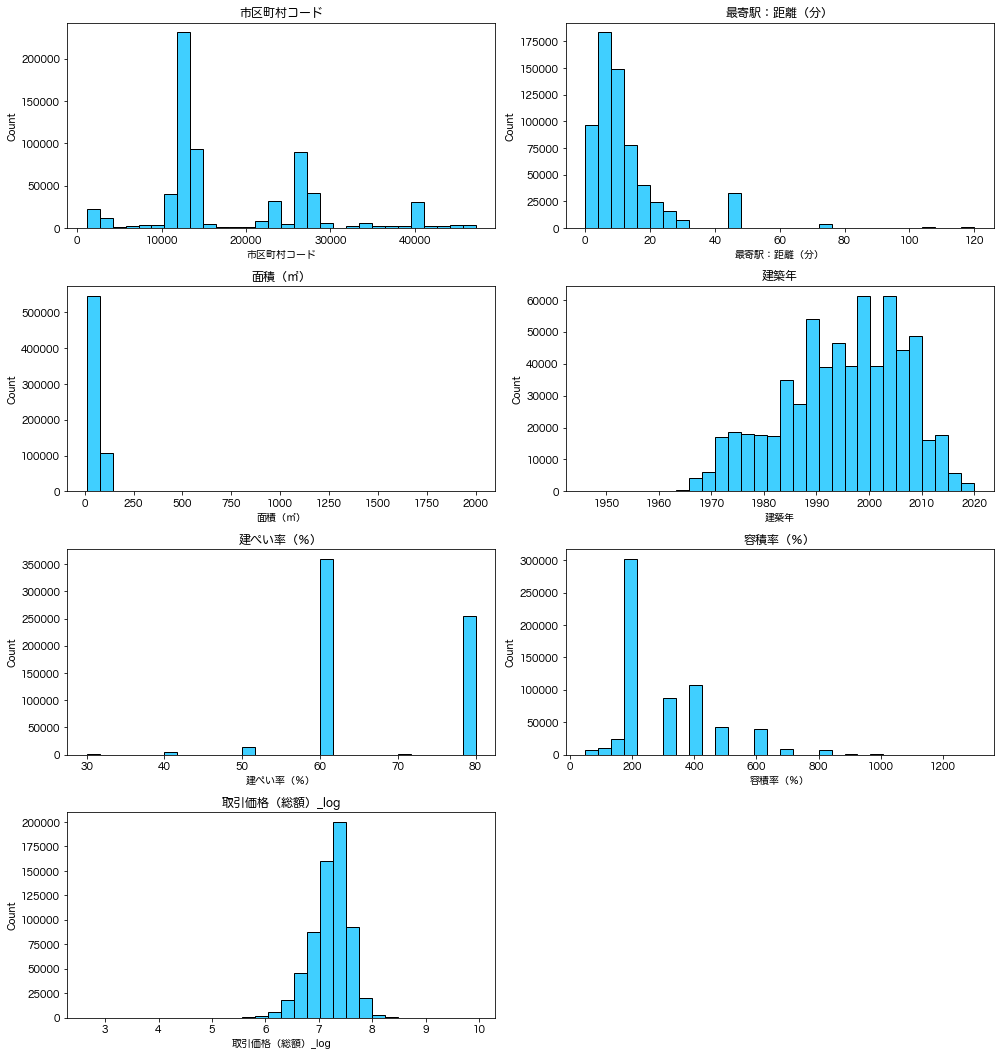

In [ ]:
plt.figure(figsize=(14,18))

for i,col in enumerate(tqdm(quantitative)):
    plt.subplot(int(len(qualitative)/2), 2, i+1)
    g = sns.histplot(all_df[col], kde=False, bins=30, color='deepskyblue')
    g.set_title( col )

plt.tight_layout()
plt.show()

### 外れ値の処理の例
面積のヒストグラムを見てみるととデータが左側に集中していることが確認でますがこれは外れ値(他のデータからみて極端に大きいもしくは小さい値)が紛れていることが原因です。  
99%点を上限にしてそれ以上の値をこの値で置き換える処理を行うことによって外れ値の置き換えを行います。

In [ ]:
p99 = all_df["面積（㎡）"].quantile(0.99)
all_df["面積（㎡）"] = all_df["面積（㎡）"].clip(0,p99)

Text(0.5, 1.0, '面積（㎡）')

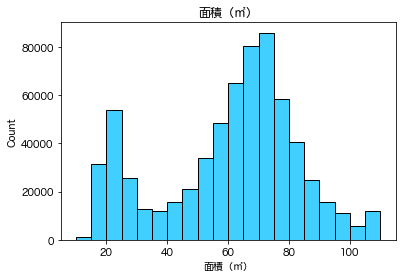

In [ ]:
plt.subplot(111)
g = sns.histplot(all_df["面積（㎡）"].clip(0,p99), kde=False, bins=20, color='deepskyblue')
g.set_title("面積（㎡）")

### カウントプロット
データの件数を集計し個数を表現するグラフです。
ヒストグラムは数値のデータしか扱えませんがカウントプロットは文字のデータも集計できます。

100%|██████████| 11/11 [00:24<00:00,  2.24s/it]


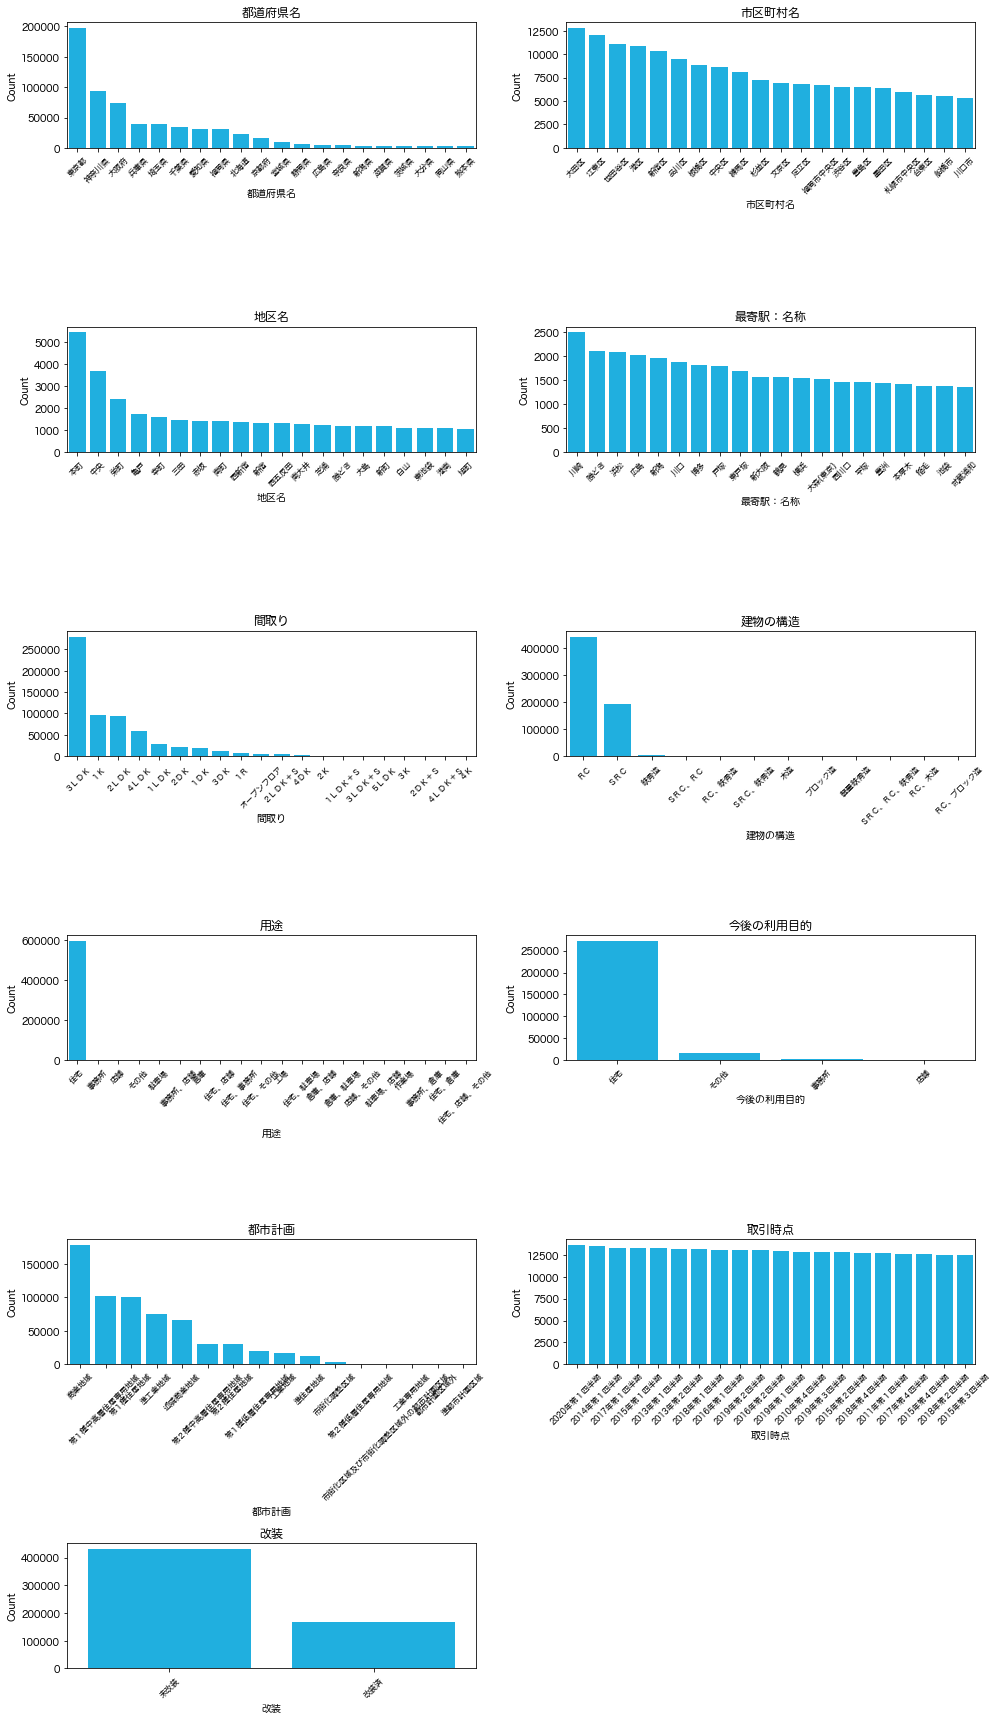

In [ ]:
plt.figure(figsize=(14,24))

for i,col in enumerate(tqdm(qualitative)):

    types = all_df[col].value_counts()[:20]
    types.index = [x for x in types.index]

    plt.subplot(int(len(qualitative)/2)+1, 2, i+1)
    g = sns.countplot(x=col,
                        data=all_df,
                        color='deepskyblue', order =types.index.values)
    g.set_title( col )
    g.set_ylabel("Count")
    g.set_xticklabels(g.get_xticklabels(),rotation=45,fontsize=8)

plt.tight_layout()
plt.show()

### ヒートマップ
相関係数行列(各列の相関係数を並べたもの)を色分けし表にしたものです。  
目的変数と説明変数や説明変数同士の相関係数を確認したいときに用いられます。

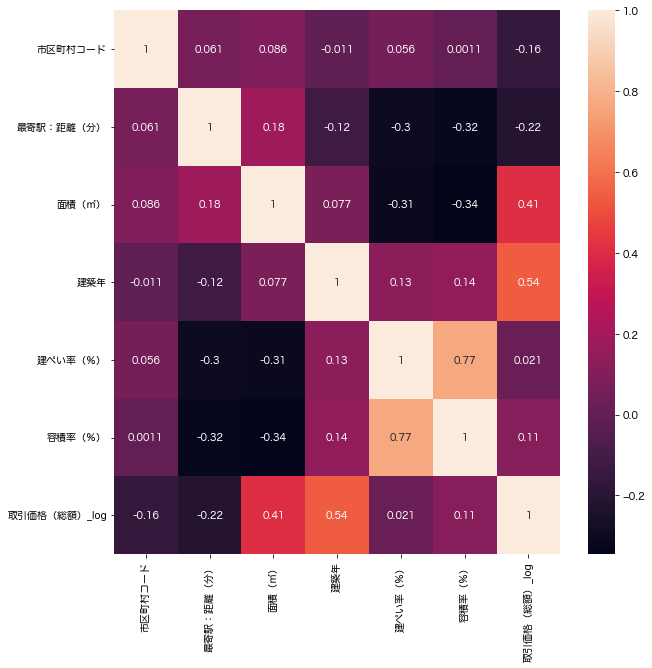

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(all_df[quantitative].corr(), annot=True)
plt.show()

文字のデータを数値のデータに変換、欠損値が75%以上の列を削除などの処理を行いましたがこのデータを新たに名前をつけて保存します。  

In [ ]:
train_df = all_df[all_df["isTest"]==0].drop("isTest", axis=1)
test_df = all_df[all_df["isTest"]==1].drop(["isTest","取引価格（総額）_log"], axis=1)

train_df.to_csv(f"{PROCESSED_DATA_DIR}01_EDA_preprocessed_train.csv", index=False)
test_df.to_csv(f"{PROCESSED_DATA_DIR}01_EDA_preprocessed_test.csv", index=False)